# 📧 Système Intelligent de Détection de Spams pour BMSecurity

## Contexte du projet
En tant que développeur IA chez **BMSecurity**, vous êtes chargé(e) de concevoir un système intelligent de détection de spams à partir d’emails, dans le cadre du renforcement de la sécurité des communications.

L’objectif est de développer un modèle de classification performant, capable de distinguer automatiquement les emails malveillants des messages légitimes, en combinant des techniques avancées de traitement du langage naturel (NLP) et d’apprentissage supervisé.

Ce notebook présente l'ensemble du pipeline : analyse exploratoire, prétraitement, extraction de caractéristiques, entraînement et évaluation de modèles, optimisation, sauvegarde et interface interactive.



# ? Objectifs et Plan du Notebook
Ce notebook détaille toutes les étapes pour concevoir un système de détection de spams :
- **Analyse exploratoire des données (EDA)** : Comprendre la structure, la distribution et les relations dans le jeu de données, visualiser les mots fréquents (spams vs hams).
- **Prétraitement du texte** : Nettoyage, tokenisation, suppression des stopwords, ponctuation, et stemming.
- **Extraction des caractéristiques** : Vectorisation TF-IDF, séparation train/test.
- **Entraînement de plusieurs modèles** : Decision Tree, Naive Bayes, SVM.
- **Évaluation et validation croisée** : Matrice de confusion, précision, rappel, F1-score, cross-validation.
- **Optimisation des hyperparamètres** : RandomizedSearchCV.
- **Sauvegarde du meilleur modèle** : Export du modèle et du vectoriseur.
- **Interface interactive (Streamlit)** : Visualisation EDA, test du modèle en temps réel.

Chaque étape est expliquée et documentée pour garantir la reproductibilité et la pédagogie.

In [3]:
# ===============================
# 1. 📦 Importation des bibliothèques
# ===============================
# Manipulation et visualisation des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Traitement du texte (NLP)
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Machine Learning et évaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# Sauvegarde des modèles
import joblib



## 📥 2. Chargement et nettoyage des données

Nous chargeons le jeu de données contenant les emails et leurs étiquettes (spam ou ham), puis procédons à un nettoyage de base :
- Vérification des colonnes
- Suppression des doublons
- Suppression des valeurs manquantes

Cela permet de garantir la qualité des données avant toute analyse ou modélisation.


In [4]:
# ===============================
# 2. 📥 Chargement & Nettoyage des données
# ===============================
# Chargement du jeu de données
df = pd.read_csv("data/DataSet_Emails.csv")
# Affichage de la forme initiale
print("Forme initiale:", df.shape)
# Suppression des doublons
print("Nombre de doublons:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
# Suppression des valeurs manquantes
print("Valeurs manquantes par colonne:\n", df.isnull().sum())
df.dropna(subset=["text"], inplace=True)
# Suppression des lignes où le texte est vide
df = df[df["text"].str.strip() != ""]
print("Forme après nettoyage:", df.shape)

Forme initiale: (31716, 8)
Nombre de doublons: 0
Valeurs manquantes par colonne:
 Unnamed: 0      0
message_id      0
text           51
label           0
label_text      0
subject       274
message       345
date            0
dtype: int64
Forme après nettoyage: (31665, 8)



---

## 📊 3. Analyse exploratoire des données (EDA)

L’EDA permet de comprendre la structure du jeu de données :
- Dimensions, types, aperçu des premières lignes
- Répartition des classes (spam vs ham)
- Analyse visuelle à travers des nuages de mots pour identifier les termes fréquents dans chaque type d’email

Cette étape est cruciale pour orienter les choix de modélisation.


In [5]:
# ===============================
# 3. 📊 Analyse exploratoire (EDA)
# ===============================
# Dimensions et types des données
print("Dimensions:", df.shape)
print("Types de variables:\n", df.dtypes)
# Aperçu des premières lignes
display(df.head())
# Statistiques descriptives
display(df.describe(include='all'))

Dimensions: (31665, 8)
Types de variables:
 Unnamed: 0     int64
message_id     int64
text          object
label          int64
label_text    object
subject       object
message       object
date          object
dtype: object


,Unnamed: 0,message_id,text,label,label_text,subject,message,date
0,0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


,Unnamed: 0,message_id,text,label,label_text,subject,message,date
count,31665.000000,31665.000000,31665,31665.000000,31665,31442,31371,31665
unique,NaN,NaN,28811,NaN,2,23028,28193,1523
top,NaN,NaN,calpine daily gas nomination >\nricky a . arch...,NaN,spam,schedule crawler : hourahead failure,click here to be removed\n,2005-07-19
freq,NaN,NaN,20,NaN,16112,168,60,431
mean,15857.384178,16857.042350,NaN,0.508827,NaN,NaN,NaN,NaN
std,9155.889212,9737.875359,NaN,0.499930,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
25%,7928.000000,8433.000000,NaN,0.000000,NaN,NaN,NaN,NaN
50%,15858.000000,16841.000000,NaN,1.000000,NaN,NaN,NaN,NaN
75%,23785.000000,25311.000000,NaN,1.000000,NaN,NaN,NaN,NaN


Distribution des emails:
 label_text
spam    16112
ham     15553
Name: count, dtype: int64


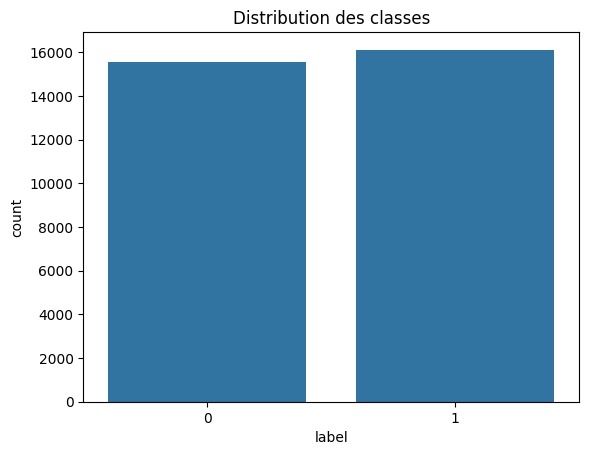

Matrice de corrélation (si applicable):


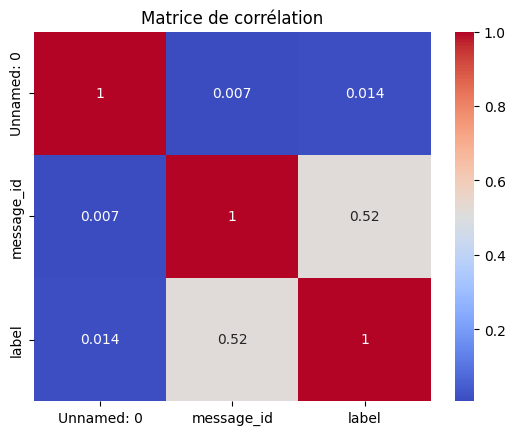

In [10]:
# Distribution des classes
nb= df['label_text'].value_counts()
print("Distribution des emails:\n", nb)
# distribution des classes
sns.countplot(x='label', data=df)
plt.title("Distribution des classes")
plt.show()

# Matrice de corrélation (si applicable)
print("Matrice de corrélation (si applicable):")
if df.select_dtypes(include=[np.number]).shape[1] > 1:
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Matrice de corrélation")
    plt.show()

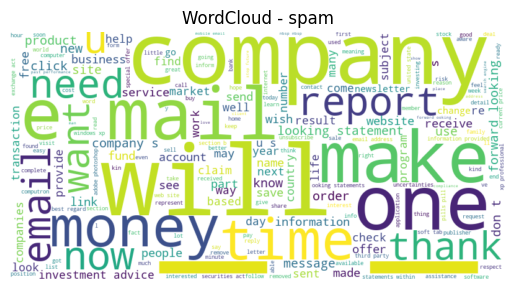

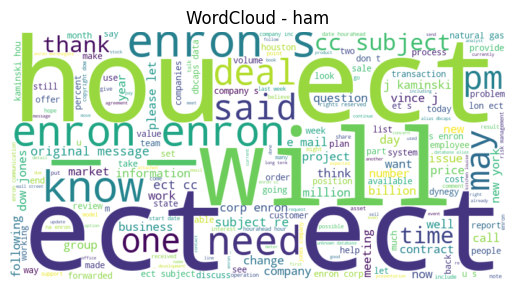

In [17]:

# ===============================
# generation des nuages de mots
# ===============================
def generate_wordcloud(data, label):
    text = " ".join(data[data['label_text'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {label}")
    plt.show()
generate_wordcloud(df, 'spam')
generate_wordcloud(df, 'ham')


---

## 🧽 4. Prétraitement des textes (NLP)

Avant de vectoriser les emails, nous appliquons plusieurs transformations textuelles :
- Conversion en minuscules
- Tokenisation
- Suppression des stopwords, de la ponctuation et des caractères spéciaux
- Stemming (réduction à la racine des mots)

Ces étapes permettent de normaliser le texte et d'améliorer la qualité de la représentation vectorielle.


In [18]:
# ===============================
# 4. 🧽 Prétraitement du texte (NLP)
# ===============================
# Téléchargement des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
# Initialisation du stemmer et des stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
# Fonction de prétraitement complète
def preprocess(text):
    text = text.lower()  # Mise en minuscules
    text = re.sub(r'\W', ' ', text)  # Suppression caractères spéciaux
    tokens = word_tokenize(text)  # Tokenisation
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(tokens)
# Application du prétraitement
df['clean_text'] = df['text'].apply(preprocess)
# Vérification du résultat
display(df[['text', 'clean_text']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,any software just for 15 $ - 99 $ understandin...,softwar 15 99 understand oem softwar lead temp...
1,perspective on ferc regulatory action client c...,perspect ferc regulatori action client conf ca...
2,wanted to try ci 4 lis but thought it was way ...,want tri ci 4 li thought way expens viagra 1 1...
3,"enron / hpl actuals for december 11 , 2000 tec...",enron hpl actual decemb 11 2000 teco tap 30 00...
4,looking for cheap high - quality software ? ro...,look cheap high qualiti softwar rotat napoleon...



---

## 🔢 5. Extraction des caractéristiques

Nous utilisons la méthode TF-IDF (Term Frequency-Inverse Document Frequency) pour convertir les textes en vecteurs numériques exploitables par les modèles de Machine Learning.

Nous séparons ensuite les données en variables explicatives `X` et variable cible `y`, puis divisons le jeu de données en ensemble d'entraînement et de test.


In [19]:
# ===============================
# 5. 🔢 Extraction des caractéristiques
# ===============================
# Vectorisation TF-IDF du texte prétraité
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']
# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Taille X_train:", X_train.shape)
print("Taille X_test:", X_test.shape)

Taille X_train: (25332, 128908)
Taille X_test: (6333, 128908)



---

## 🤖 6. Entraînement de plusieurs modèles

Nous testons différents algorithmes de classification supervisée :
- Naive Bayes
- Arbre de Décision (Decision Tree)
- SVM (Support Vector Machine)

Le but est de comparer leurs performances afin de sélectionner le plus performant.



NaiveBayes Results:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3120
           1       0.98      0.99      0.98      3213

    accuracy                           0.98      6333
   macro avg       0.98      0.98      0.98      6333
weighted avg       0.98      0.98      0.98      6333



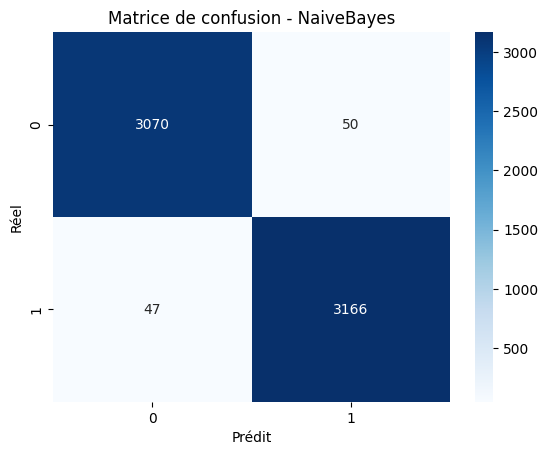


SVM Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3120
           1       0.98      1.00      0.99      3213

    accuracy                           0.99      6333
   macro avg       0.99      0.99      0.99      6333
weighted avg       0.99      0.99      0.99      6333



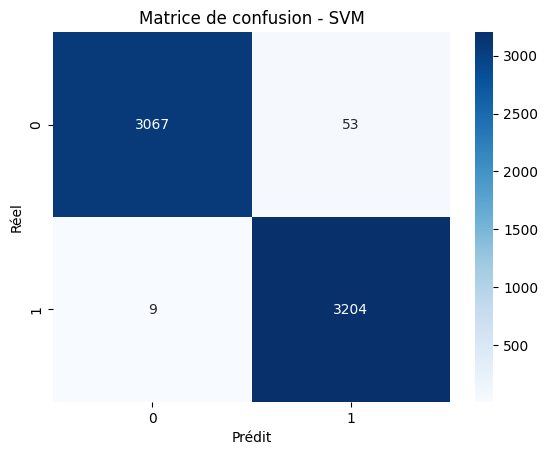


DecisionTree Results:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3120
           1       0.96      0.97      0.97      3213

    accuracy                           0.97      6333
   macro avg       0.97      0.97      0.97      6333
weighted avg       0.97      0.97      0.97      6333



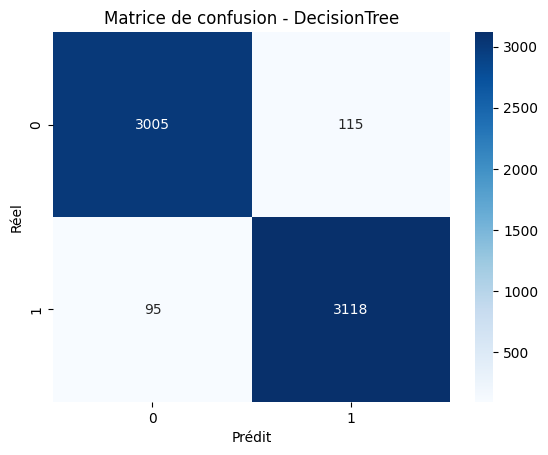

In [20]:
# ===============================
# 6. 🤖 Entraînement de plusieurs modèles
# ===============================
models = {
    'NaiveBayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'DecisionTree': DecisionTreeClassifier()
}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.show()


---

## 📈 7. Évaluation des modèles

À l’aide de métriques standards :
- Matrice de confusion
- Précision
- Rappel
- F1-score

Nous évaluons la qualité de chaque modèle sur le jeu de test, afin d’avoir une vision claire de leurs performances respectives.



---

## 🔁 8. Validation croisée (Cross-validation)

Pour renforcer la robustesse de l’évaluation, nous utilisons une validation croisée à 5 plis. Cela permet de tester le modèle sur différentes sous-parties du dataset et de vérifier sa stabilité.


NaiveBayes: F1-macro moyen = 0.985 (+/- 0.001)
SVM: F1-macro moyen = 0.990 (+/- 0.001)
SVM: F1-macro moyen = 0.990 (+/- 0.001)
DecisionTree: F1-macro moyen = 0.958 (+/- 0.003)
DecisionTree: F1-macro moyen = 0.958 (+/- 0.003)


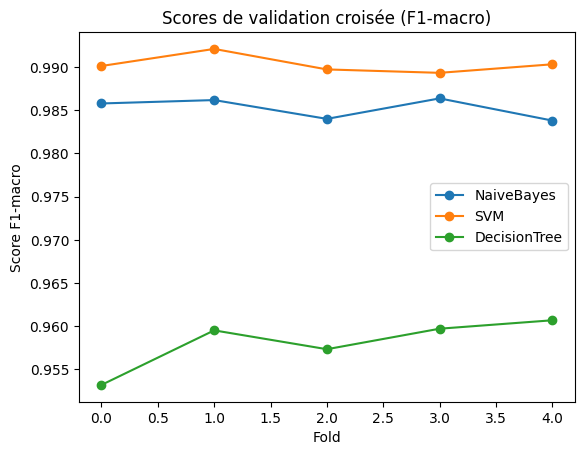

In [21]:
# ===============================
# 8. 🔁 Validation croisée
# ===============================
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    print(f"{name}: F1-macro moyen = {scores.mean():.3f} (+/- {scores.std():.3f})")
    plt.plot(scores, marker='o', label=name)
plt.title("Scores de validation croisée (F1-macro)")
plt.xlabel("Fold")
plt.ylabel("Score F1-macro")
plt.legend()
plt.show()


---

## 🔧 9. Optimisation des hyperparamètres

Nous utilisons `GridSearchCV` pour optimiser les paramètres du modèle SVM. Cette méthode permet de tester plusieurs combinaisons de paramètres pour identifier celle qui donne les meilleurs résultats.


In [24]:
# ===============================
# 9. 🔧 Optimisation des hyperparamètres (SVM)
# ===============================
# Définition de la grille de recherche
from sklearn.svm import LinearSVC

param_dist = {
    'C': [0.1, 1, 10]
}
random_search = RandomizedSearchCV(
    estimator=LinearSVC(),
    param_distributions=param_dist,
    n_iter=3,  # car peu de combinaisons
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=2,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
print("Meilleurs paramètres SVM:", random_search.best_params_)
print("Meilleur score cross-val:", random_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Meilleurs paramètres SVM: {'C': 10}
Meilleur score cross-val: 0.9900915805583779
Meilleurs paramètres SVM: {'C': 10}
Meilleur score cross-val: 0.9900915805583779



---

## 💾 10. Sauvegarde du meilleur modèle

Le meilleur modèle et le vectoriseur TF-IDF sont sauvegardés avec `joblib`, afin de pouvoir être réutilisés dans une application (Streamlit par exemple) sans devoir les réentraîner.


In [30]:
# ===============================
# 10. 💾 Sauvegarde du meilleur modèle et du vectoriseur
# ===============================
# Sauvegarde du meilleur modèle SVM et du vectoriseur TF-IDF
best_model = random_search.best_estimator_
joblib.dump(best_model, 'models/model.pkl')
joblib.dump(vectorizer, 'models/vectorizer.pkl')
print("Modèle et vectoriseur sauvegardés dans le dossier models/")

Modèle et vectoriseur sauvegardés dans le dossier models/



---

## 🌐 11. Interface interactive avec Streamlit

Une application web interactive a été développée avec Streamlit pour :
- Visualiser les résultats de l’EDA (graphiques, word clouds) ;
- Tester le modèle en temps réel via une zone de saisie d’email ;
- Afficher le résultat (Spam ou Ham) et la probabilité de prédiction.

Pour lancer l’application :
```bash
streamlit run notebooks/app.py
```

## 📄 Documentation et reproductibilité

Chaque étape du notebook est expliquée pour garantir la compréhension et la reproductibilité du projet. Consultez le fichier `README.md` pour la structure du projet et les instructions d’exécution.
